In [237]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

BATCH_SIZE = 8
MODEL_SHAPE = (256,  256)
EPOCHS = 200

In [238]:
labeled_dir = "./../data/labeled/"
unlabeled_dir = "./../data/unlabeled/"

unlabeled_paths = []
for root, dirs, files in os.walk(unlabeled_dir):
    for name in files:
        unlabeled_paths.append(os.path.join(root, name))

labeled_paths = []
for root, dirs, files in os.walk(labeled_dir):
    for name in files:
        labeled_paths.append(os.path.join(root, name))

unlabeled_paths.sort()
labeled_paths.sort()

In [239]:

input_pairs = {}
count = 0
for unlabeled_path in unlabeled_paths:
    img = cv2.imread(unlabeled_path)
    if(img.shape[0] < 256) or (img.shape[1] < 256):
        print("Error. Needed shape (800,800), but found ", img.shape[:2])
    else:
        input_pairs[unlabeled_path] = labeled_paths[count]
    count = count + 1

In [240]:
def normalize(paths, batchsize=8, outshape=(256, 256)):
    counter = 0
    img_batch = []
    mask_batch = []
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    for imgpath in paths.keys():
        counter += 1
        img = cv2.imread(imgpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        img = cv2.filter2D(img, -1, kernel)
        img = cv2.resize(img, outshape) / 255
        
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask = cv2.resize(mask, outshape)
        tmpmask = cv2.imread(paths[imgpath], 0)
        tmpmask = cv2.resize(tmpmask, outshape)
        mask = cv2.bitwise_or(mask, tmpmask)
        mask = np.expand_dims(mask, -1) / 255
            
        img_batch.append(img[np.newaxis, ...])
        mask_batch.append(mask[np.newaxis, ...])
        if counter % batchsize == 0:
            yield np.concatenate(img_batch, axis=0), np.concatenate(mask_batch, axis=0)
            counter = 0
            img_batch = []
            mask_batch = []

In [241]:
# Training and Validation Split
train_size = 8
training_paths = dict(list(input_pairs.items())[:train_size])
validation_paths = dict(list(input_pairs.items())[:train_size])

Batch size: (8, 256, 256, 3) (8, 256, 256, 1)


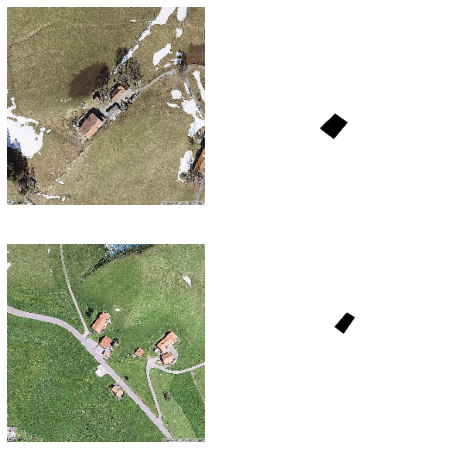

In [242]:
# Visualization
imgs, masks = next(normalize(input_pairs))
print("Batch size:", imgs.shape, masks.shape)
plt.figure(figsize=(8,8))
plt.tight_layout()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(imgs[4])
plt.subplot(2,2,2)
plt.axis('off')
plt.imshow(masks[4].reshape(masks[4].shape[:2]), cmap='gray')
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(imgs[2])
plt.subplot(2,2,4)
plt.axis('off')
plt.imshow(masks[2].reshape(masks[2].shape[:2]), cmap='gray')
plt.show()

In [243]:
# Augmentation
traingen = normalize(training_paths, len(training_paths), MODEL_SHAPE)
trainX, trainY = next(traingen)
print("trainX shape: {} trainY shape: {}".format(trainX.shape, trainY.shape))
# Validation mask and images generator
valgen = normalize(validation_paths, len(validation_paths), MODEL_SHAPE)
valX, valY = next(valgen)
print("valX shape: {} valY shape: {}".format(valX.shape, valY.shape))
# Keras Training Generator for Augmentation
trainKgen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=12, 
                               width_shift_range=0.10, 
                               shear_range=0.5,
                               height_shift_range=0.10, 
                               zoom_range=0.10                            )

trainX shape: (8, 256, 256, 3) trainY shape: (8, 256, 256, 1)
valX shape: (8, 256, 256, 3) valY shape: (8, 256, 256, 1)


In [244]:
from nn import get_model

model = get_model()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.BinaryAccuracy(), tf.metrics.FalseNegatives()]
# )
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -tf.keras.backend.mean( (intersection + eps) / (union + eps), axis=0)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])

# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mse', metrics=['mae'])


In [245]:
weights_path = "./../data/weights/weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(weights_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_weights_only=True
                            )
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.2,
                                   patience=1, 
                                   verbose=1, 
                                   mode='min',
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=1e-8
                                  )
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose=2,
                      patience=20 # probably needs to be more patient
                     )

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [246]:
import scipy
try:
    model.load_weights(weights_path)
except:
    print("No checkpoint")
    pass

train_res = model.fit(
    # x=trainKgen.flow(trainX, trainY, batch_size=BATCH_SIZE),
    # validation_data=(valX, valY),
    # validation_steps=1,
    # callbacks=callbacks_list
    trainX, trainY, epochs=EPOCHS, steps_per_epoch=len(training_paths) / 2, validation_data=(valX, valY),
)

No checkpoint
Epoch 1/200
4/4 [==============================] - 17s 3s/step - loss: 0.2774 - mae: 0.5022 - val_loss: 0.2521 - val_mae: 0.5020
Epoch 2/200
4/4 [==============================] - 11s 3s/step - loss: 0.2087 - mae: 0.4285 - val_loss: 0.2497 - val_mae: 0.4997
Epoch 3/200
4/4 [==============================] - 11s 3s/step - loss: 0.1577 - mae: 0.3684 - val_loss: 0.2455 - val_mae: 0.4955
Epoch 4/200
4/4 [==============================] - 10s 3s/step - loss: 0.1227 - mae: 0.3245 - val_loss: 0.2386 - val_mae: 0.4884
Epoch 5/200
4/4 [==============================] - 12s 3s/step - loss: 0.0977 - mae: 0.2891 - val_loss: 0.2309 - val_mae: 0.4805
Epoch 6/200
4/4 [==============================] - 11s 3s/step - loss: 0.1113 - mae: 0.2973 - val_loss: 0.2235 - val_mae: 0.4726
Epoch 7/200
4/4 [==============================] - 12s 3s/step - loss: 0.0851 - mae: 0.2626 - val_loss: 0.2177 - val_mae: 0.4665
Epoch 8/200
4/4 [==============================] - 12s 3s/step - loss: 0.0742 - mae

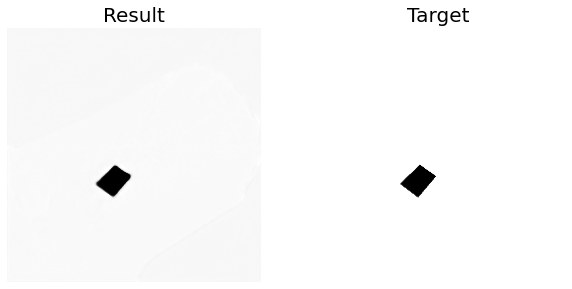

In [249]:
img_no = 4
testimg = trainX[img_no].reshape(1, 256, 256, 3)
# TEST OUT WITH SINGLE IMAGE
targetmask = trainY[img_no].reshape(MODEL_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Result', fontsize=20)
plt.imshow(pred.reshape(MODEL_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()

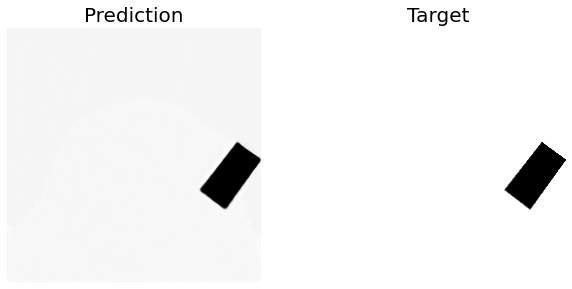

In [250]:
# VALIDATION
img_no = 3
testimg = valX[img_no].reshape(1, 256, 256, 3)
targetmask = valY[img_no].reshape(MODEL_SHAPE)
pred = model.predict(testimg)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Prediction', fontsize=20)
plt.imshow(pred.reshape(MODEL_SHAPE), cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Target', fontsize=20)
plt.imshow(targetmask, cmap='gray')
plt.show()